In [1]:
import numpy as np
import matplotlib.pyplot as plt

import synth
from IPython.display import Audio, display
import librosa

import utils

2025-07-11 15:43:10.462182: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-11 15:43:10.639665: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-11 15:43:10.673222: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-11 15:43:10.688331: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-11 15:43:10.895657: I tensorflow/core/platform/cpu_feature_guar

In [2]:
filtered_saw = synth.filter_audio(synth.sawtooth_wave([1], [200], 10), synth.sawtooth_wave([1], [0.4], 10)*1400 + 1500, True)

display(Audio(filtered_saw, rate=44100))
plt.figure(figsize=(10, 4))
plt.plot(filtered_saw[:1000])
plt.title("Filtered Sawtooth Wave")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.grid()
plt.show()

AttributeError: module 'synth' has no attribute 'filter_audio'

In [3]:
sine = synth.sine_wave([1], [250], 10)
display(Audio(sine, rate=44100))

clipped_sine = synth.soft_clip(sine, [1, 5, 2, 30])
display(Audio(clipped_sine, rate=44100))

In [4]:
def find_peaks(y):

    peaks = np.where((y[1:-1] > y[0:-2]) * (y[1:-1] > y[2:]))[0] + 1
    dips = np.where((y[1:-1] < y[0:-2]) * (y[1:-1] < y[2:]))[0] + 1

    return np.sort(np.concatenate((peaks, dips)))

[22048 33073 44098 55123 66148 77174]


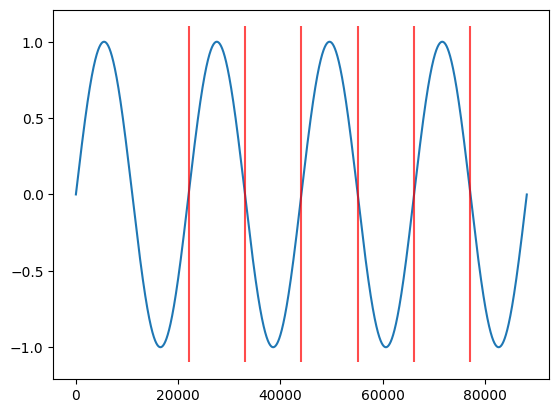

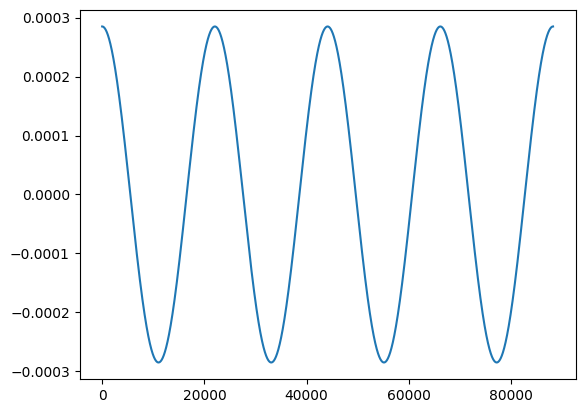

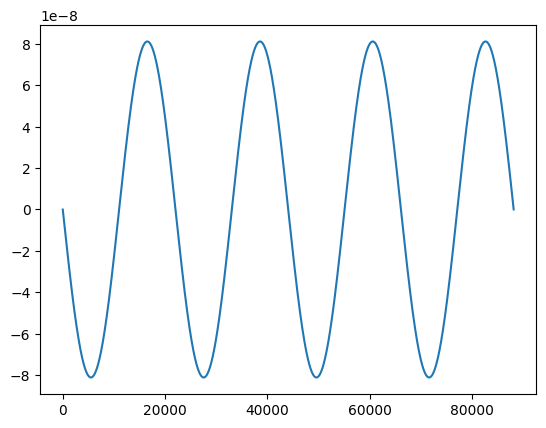

In [5]:
adsr = np.tile(synth.adsr(0.2, 0.2, 0.6, 0.2, 0.2, 2),2)
adsr = synth.sine_wave([1], [2], 2)
diff = np.diff(adsr)

plt.plot(adsr)
peaks = find_peaks(diff)
print(peaks)
plt.vlines(peaks, ymin=plt.ylim()[0], ymax=plt.ylim()[1], colors='red', alpha=0.7, label="peaks")

plt.show()

plt.plot(diff)
plt.show()

d_diff = np.diff(diff)
plt.plot(d_diff)
plt.show()


In [6]:
peaks = find_peaks(diff)

print(peaks)

[22048 33073 44098 55123 66148 77174]


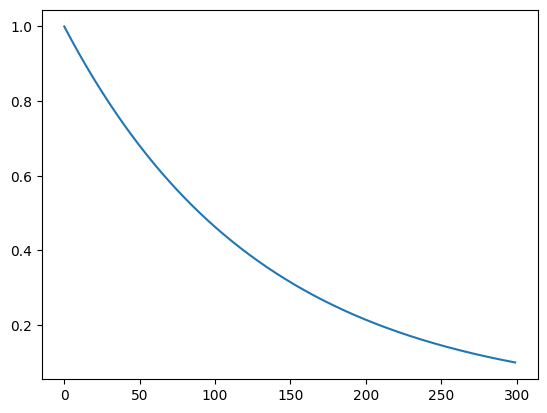

In [7]:
adsr = np.tile(synth.adsr(0.01, 0.2, 0, 0.2, 0.1),2)
audio = synth.sawtooth_wave(adsr, [440], 4)
audio = synth.delay(audio)

display(Audio(audio, rate=44100))

plt.plot(np.logspace(1,0,300)/10)

sine shape: (2048,), triangular shape: (2048,)


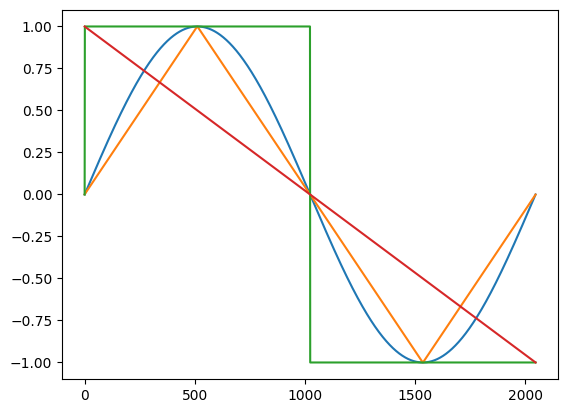

In [26]:
samples = 2048

sine = np.sin(np.linspace(0, 2 * np.pi, samples))
triangular =  np.roll(np.concatenate((np.linspace(-1, 1, int(samples/2)), np.linspace(1, -1, int(samples/2)))), int(-samples/4))
square = np.sign(sine)
sawtooth = np.linspace(1, -1, samples)


print(f"sine shape: {sine.shape}, triangular shape: {triangular.shape}")

plt.plot(sine)
plt.plot(triangular)
plt.plot(square)
plt.plot(sawtooth)

interpolated_wavetable

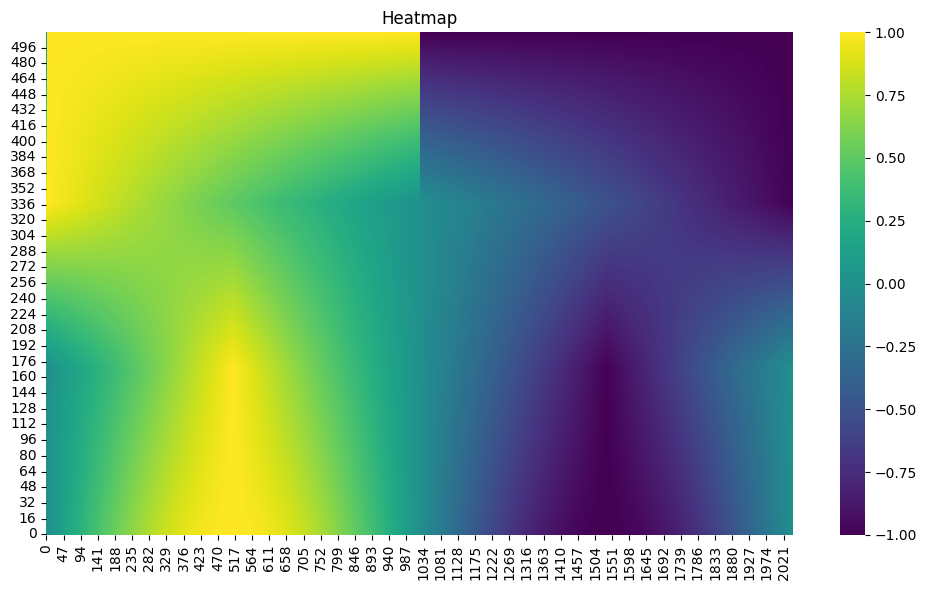

In [40]:
from scipy.interpolate import interp1d



keys = np.array([sine, triangular, sawtooth, square])  # Transpose to have shape (samples, 4)
positions = [0, 0.33, 0.66, 1.0]  # Corresponding positions for interpolation

# Build interpolator
interp = interp1d(positions, keys, axis=0)

# Evaluate at new blend positions
blend_positions = np.linspace(0, 1, 512)
result = interp(blend_positions)

utils.plot_heatmap(result)

In [41]:
def wavetable_osc(amp, frequency, shape, wavetable, duration=1.0, sr=44100):
    num_samples = int(sr * duration)
    amplitudes = utils.stretch_array(amp, num_samples)
    frequencies = utils.stretch_array(frequency, num_samples)
    shapes = utils.stretch_array(shape, num_samples)
    
    phase = np.cumsum(frequencies) / sr
    
    # Simple lookup with linear interpolation
    wave_indices = shapes * (wavetable.shape[0] - 1)
    table_positions = (phase % 1.0) * wavetable.shape[1]
    
    # You can optimize this with scipy.interpolate for even smoother results
    output = np.zeros(num_samples)
    for i in range(num_samples):
        wave_idx = int(wave_indices[i])
        pos_idx = int(table_positions[i]) % wavetable.shape[1]
        output[i] = wavetable[wave_idx, pos_idx]
    
    return amplitudes * output

# Example usage
amp = [0.5]
frequency = [440, 220, 110, 880]  # Frequencies to blend between
shape = [0.0, 0.33, 0.66, 1.0]  # Blend positions for the wavetable
wavetable = result  # Use the interpolated wavetable

audio = wavetable_osc(amp, frequency, shape, wavetable, duration=10.0)
display(Audio(audio, rate=44100))


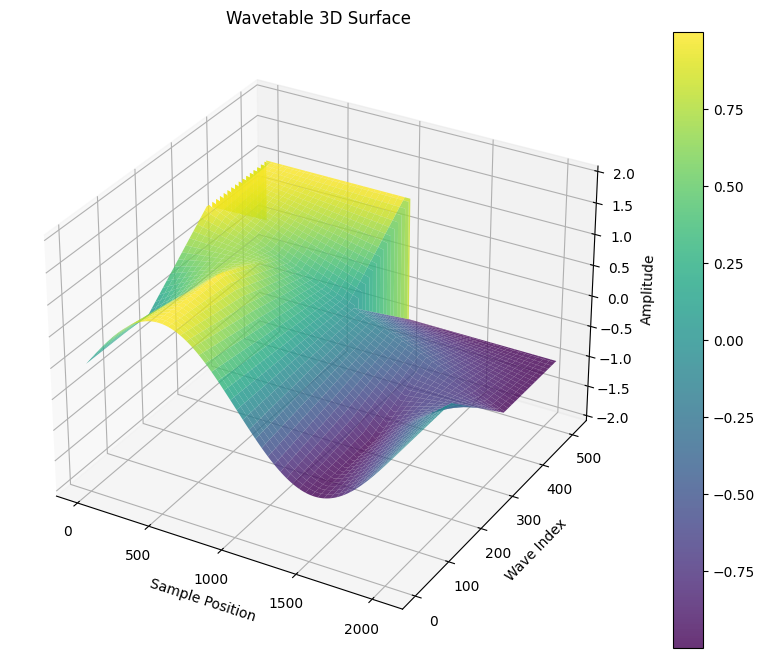

In [42]:
def plot_wavetable_3d(wavetable):
    """3D surface plot of the wavetable"""
    from mpl_toolkits.mplot3d import Axes3D
    
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Create coordinate grids
    X, Y = np.meshgrid(np.arange(wavetable.shape[1]), np.arange(wavetable.shape[0]))
    Z = wavetable
    ax.set_zlim(np.min(Z)*2, np.max(Z)*2)  # Set z-axis limits
    
    # Plot surface
    surf = ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.8)
    ax.set_xlabel('Sample Position')
    ax.set_ylabel('Wave Index')
    ax.set_zlabel('Amplitude')
    ax.set_title('Wavetable 3D Surface')
    
    plt.colorbar(surf)
    plt.show()

plot_wavetable_3d(result)

In [5]:
import wavetablesynth
from IPython.display import Audio, display

wavetablesynth = wavetablesynth.WavetableSynth()
wavetablesynth.base_freq = 200
wavetablesynth.carr_shape = 0.6
audio = wavetablesynth.render()

display(Audio(audio, rate=44100))

mod_audio shape: (441000,), samples: 441000
